In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "----->", itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
def build_dataset(words):

    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "----->", itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
C = torch.randn((27, 2)) # we embed our 27 character to 2 dimensional space.

In [10]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [11]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.rand((100, 27))
b2 = torch.rand(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()

In [18]:
prob = counts / counts.sum(1, keepdim=True)

In [19]:
prob.shape

torch.Size([228146, 27])

In [20]:
loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(5.6014)

In [21]:
# ------ now made respectable : ------------

In [22]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [102]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [103]:
sum(p.nelement() for p in parameters) # number of the parameters in total

11897

In [104]:
for p in parameters:
    p.requires_grad = True

In [105]:
lossi = []
stepi = []

In [106]:
for i in range(200000):
    # minibatches
    ix = torch.randint(0, Xtr.shape[0], (128,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (100, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.001 * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

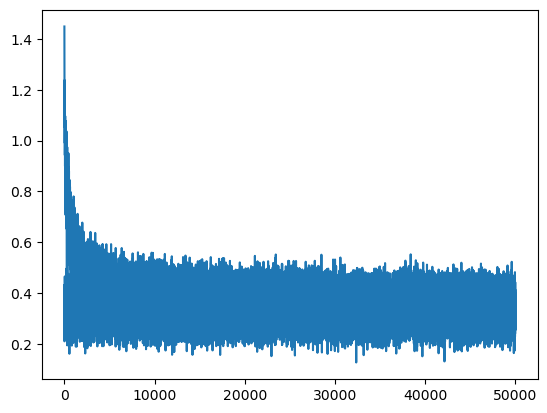

In [ ]:
plt.plot(stepi, lossi)

In [93]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1537861824035645


In [94]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1780776977539062


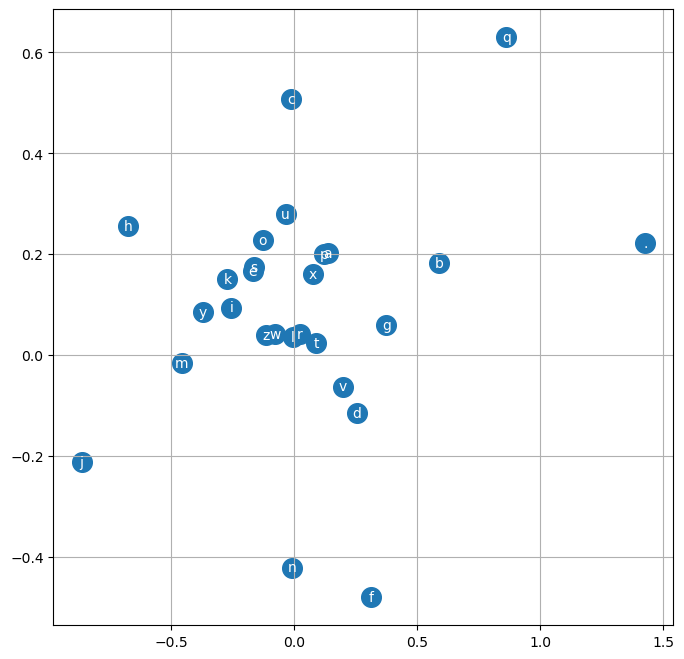

In [95]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [118]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        next_char = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [next_char]
        out.append(next_char)

        if next_char == 0:
            break

    print("".join(itos[i] for i in out))

ceri.
karalyus.
ila.
kayha.
malistana.
nrakayk.
kaida.
samiyah.
jaber.
gotox.
molteckinu.
kentedo.
kaley.
maside.
eakainen.
ryslli.
hlliden.
tahlas.
kasdro.
aneil.
